In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import pickle

from utils import imshow, RGBImage, RGBRandomSet, set_indicator_to_values

In [2]:
# nacitanie obrazkov
file_names = os.listdir("img/faces_input")
images = []
is_man = []
is_young = []
is_old = []

for file in file_names:
    im = cv.imread(f"img/faces_input/{file}", cv.IMREAD_COLOR)
    im = RGBImage(cv.resize(im, (256,256)))
    is_man.append("M" in file)
    is_young.append("a" in file)
    is_old.append("c" in file)
    images.append(im)

In [3]:
# zadelenie do uvazovanych skupin (muzi, zeny, mladsi, starsi)
man_images = [im for i,im in enumerate(images) if is_man[i]]
woman_images = [im for i,im in enumerate(images) if not is_man[i]]
young_images = [im for i,im in enumerate(images) if is_young[i]]
old_images = [im for i,im in enumerate(images) if is_old[i]]

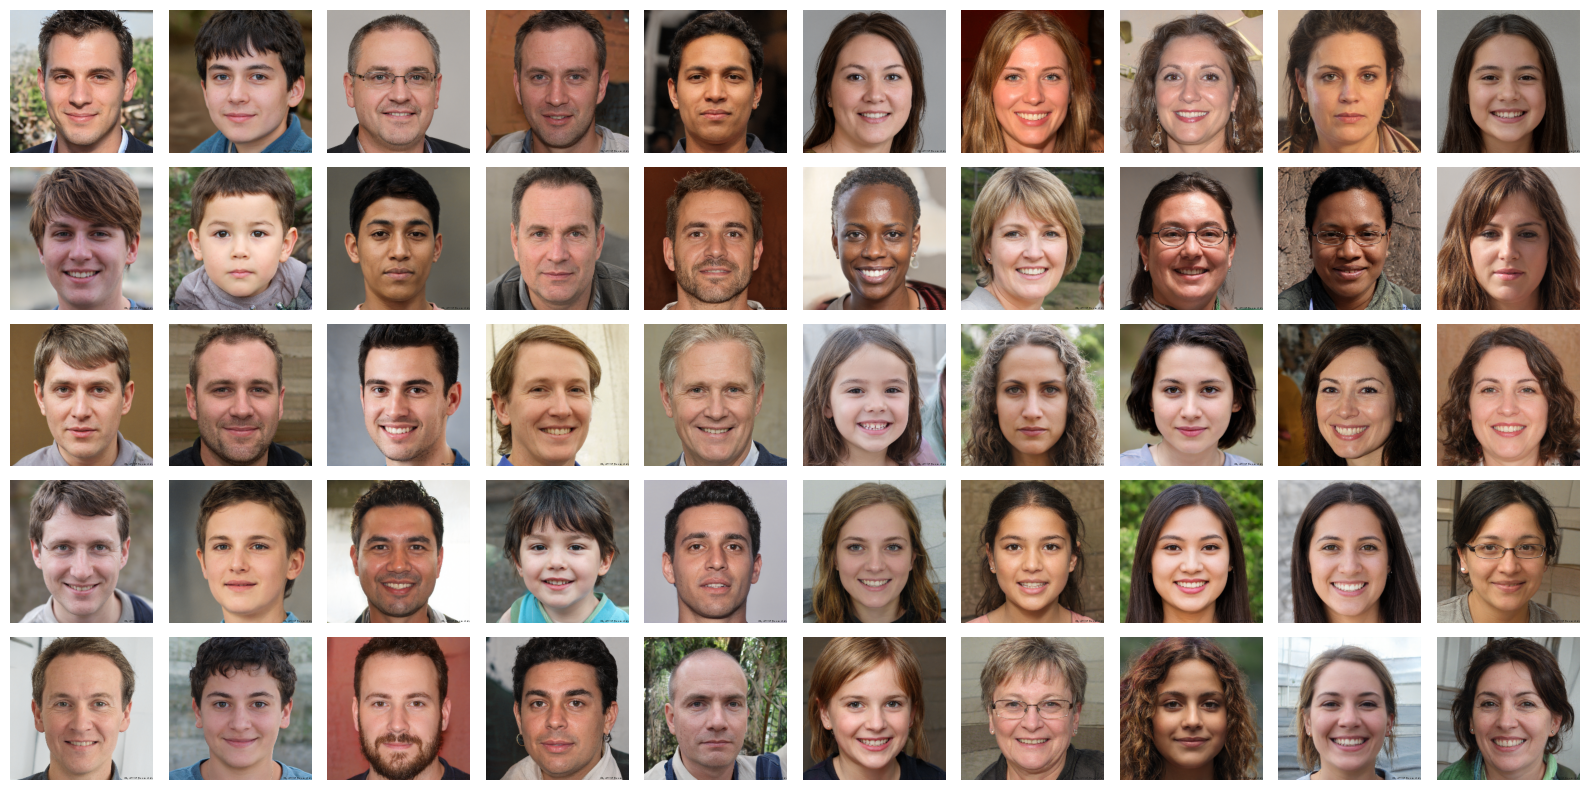

In [4]:
# vykreslenie vsetkych obrazkov
fig, ax = plt.subplots(5,10, figsize=(16,8))

for i in range(50):
    plt.setp(ax[i//10,i%10], xticks=[], yticks=[])
    if i%10 < 5:
        imshow(man_images[5*(i//10)+i%10], ax=ax[i//10,i%10])
    else:
        imshow(woman_images[5*((i-5)//10)+(i-5)%10], ax=ax[i//10,i%10])
        
plt.tight_layout()
plt.show()

In [64]:
# vytvorenie nahodnej mnoziny a vypocet Vorobyev + ODA
# POZOR, cele trvanie bunky je priblizne 30 minut!
# v dalsej bunke je mozne nacitat vysledky tejto bunky zo suboru

RS_all = RGBRandomSet(images)               # trvanie 3 min
RS_men = RGBRandomSet(man_images)           # trvanie 1,5 min
RS_women = RGBRandomSet(woman_images)       # trvanie 1,5 min
RS_young = RGBRandomSet(young_images)       # trvanie 1 min
RS_old = RGBRandomSet(old_images)           # trvanie 1 min

_ = RS_all.vorobyev_expectation()           # trvanie <5 sec
_ = RS_men.vorobyev_expectation()           # trvanie <5 sec
_ = RS_women.vorobyev_expectation()         # trvanie <5 sec
_ = RS_young.vorobyev_expectation()         # trvanie <5 sec
_ = RS_old.vorobyev_expectation()           # trvanie <5 sec

_ = RS_all.oda_expectation()                # trvanie 8 min
_ = RS_men.oda_expectation()                # trvanie 4,5 min
_ = RS_women.oda_expectation()              # trvanie 4,5 min
_ = RS_young.oda_expectation()              # trvanie 3 min
_ = RS_old.oda_expectation()                # trvanie 3 min

In [6]:
# nacitanie nahodnych mnozin s vypocitanymi strednymi hodnotami zo suboru

with open("files/RS_all.pickle", "rb") as f: RS_all = pickle.load(f)
with open("files/RS_men.pickle", "rb") as f: RS_men = pickle.load(f)
with open("files/RS_women.pickle", "rb") as f: RS_women = pickle.load(f)
with open("files/RS_young.pickle", "rb") as f: RS_young = pickle.load(f)
with open("files/RS_old.pickle", "rb") as f: RS_old = pickle.load(f)

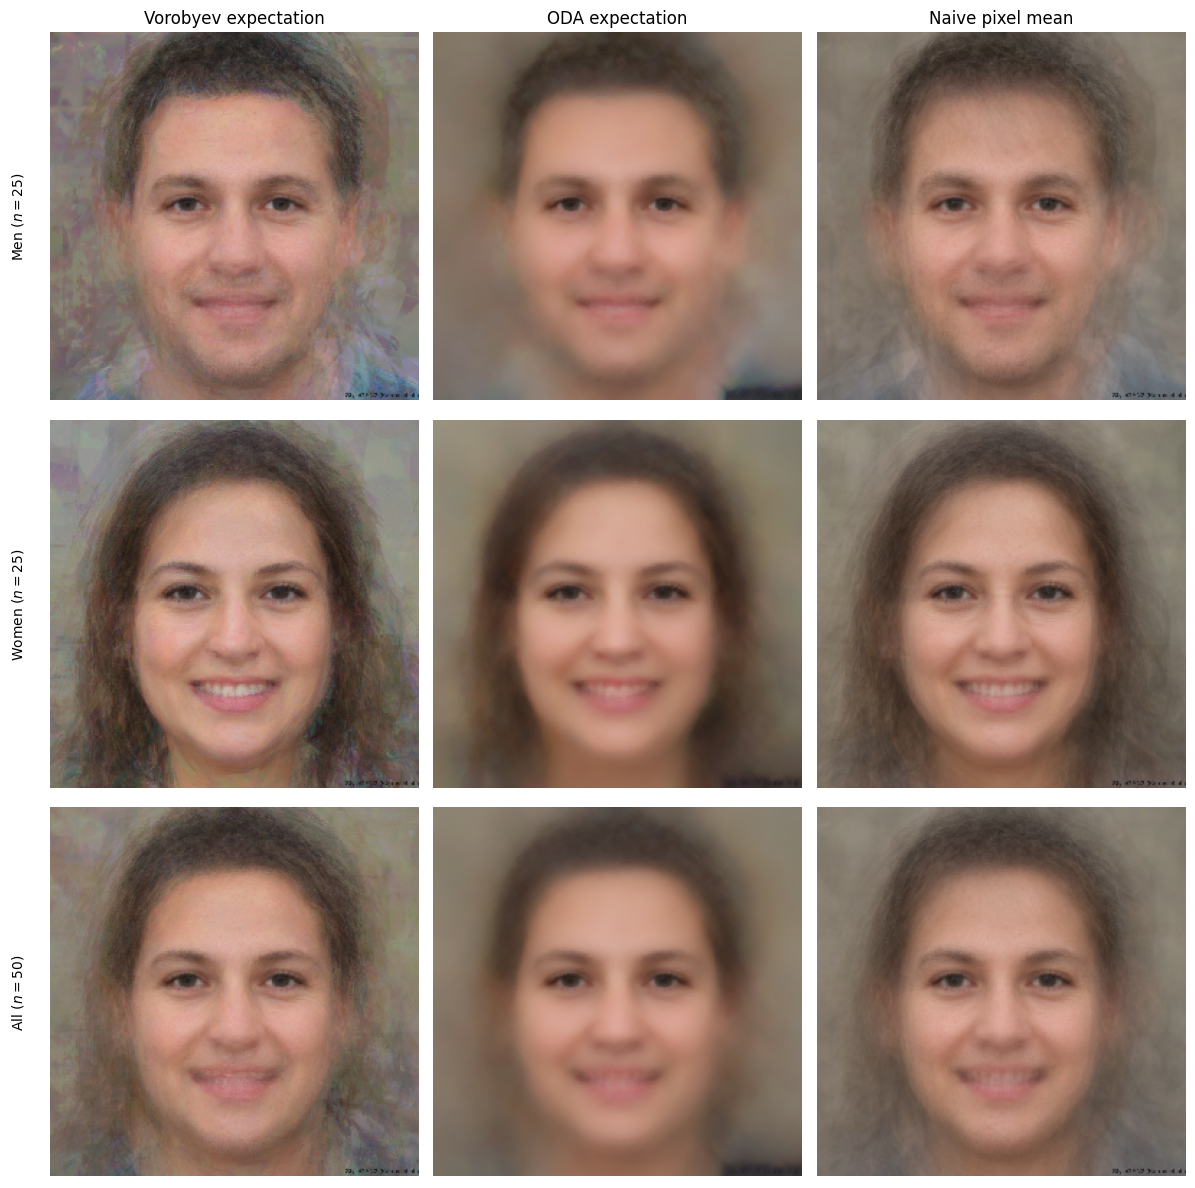

In [8]:
# vysledky priemerovania - vsetci, muzi, zeny
# aj porovnanie s priemerom po pixeloch

fig, ax = plt.subplots(3,4, figsize=(12.05,12), width_ratios=[.01,1,1,1])

ax[0,1].set_title("Vorobyev expectation")
ax[0,2].set_title("ODA expectation")
ax[0,3].set_title("Naive pixel mean")


for i,rs in enumerate([RS_men, RS_women, RS_all]):
    imshow(rs.vorobyev_expectation(), ax=ax[i,1])
    
    imshow(rs.oda_expectation(), ax=ax[i,2])
    
    naive_mean = np.uint8(np.mean([cv.merge([im.canals["red"].values, im.canals["green"].values, im.canals["blue"].values]) for im in rs.images],axis=0))
    imshow(naive_mean, ax=ax[i,3])

for i in range(3):
    ax[i,0].spines[["top","right","bottom","left"]].set_visible(False)
    plt.setp(ax[i,0], xticks=[], yticks=[])
ax[0,0].set_ylabel("Men ($n=25$)")
ax[1,0].set_ylabel("Women ($n=25$)")
ax[2,0].set_ylabel("All ($n=50$)")

plt.tight_layout()
plt.show()

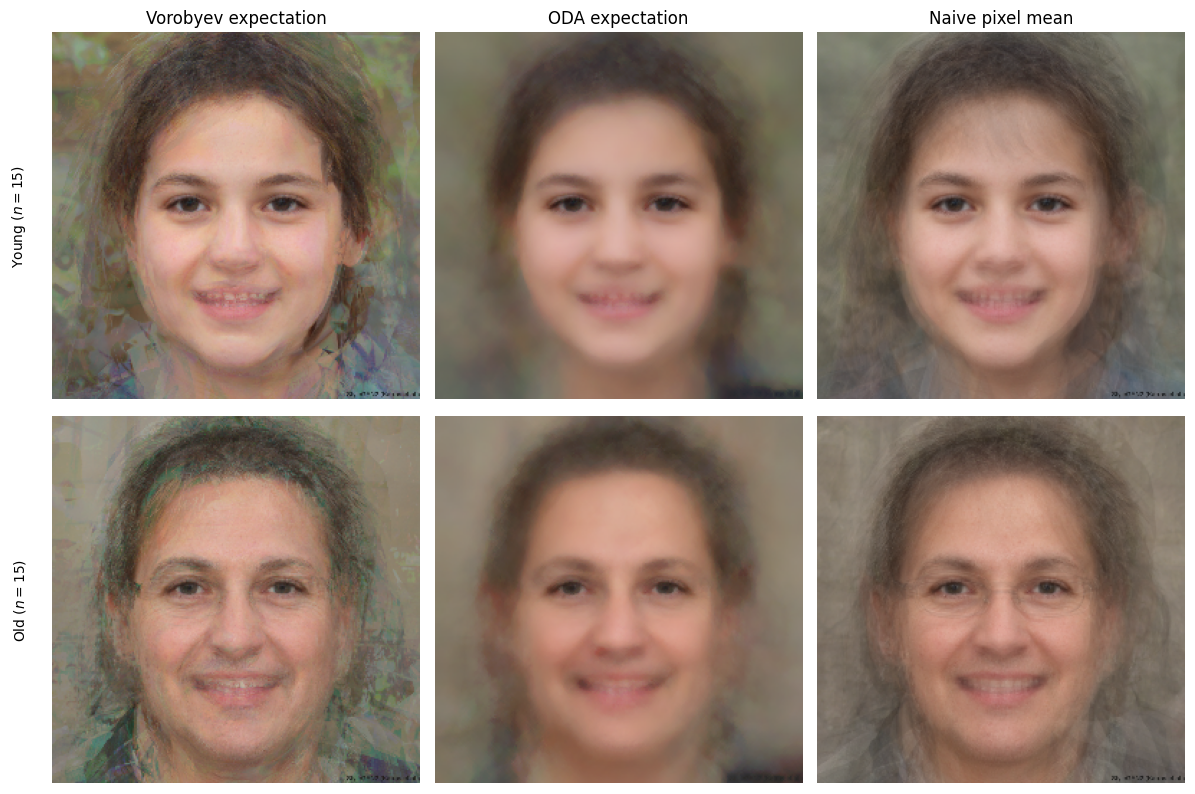

In [7]:
# vysledky priemerovania - mladsi, starsi
# aj porovnanie s priemerom po pixeloch

fig, ax = plt.subplots(2,4, figsize=(12.05,8), width_ratios=[.01,1,1,1])

ax[0,1].set_title("Vorobyev expectation")
ax[0,2].set_title("ODA expectation")
ax[0,3].set_title("Naive pixel mean")


for i,rs in enumerate([RS_young, RS_old]):
    imshow(rs.vorobyev_expectation(), ax=ax[i,1])
    
    imshow(rs.oda_expectation(), ax=ax[i,2])
    
    naive_mean = np.uint8(np.mean([cv.merge([im.canals["red"].values, im.canals["green"].values, im.canals["blue"].values]) for im in rs.images],axis=0))
    imshow(naive_mean, ax=ax[i,3])

for i in range(2):
    ax[i,0].spines[["top","right","bottom","left"]].set_visible(False)
    plt.setp(ax[i,0], xticks=[], yticks=[])
ax[0,0].set_ylabel("Young ($n=15$)")
ax[1,0].set_ylabel("Old ($n=15$)")

plt.tight_layout()
plt.show()

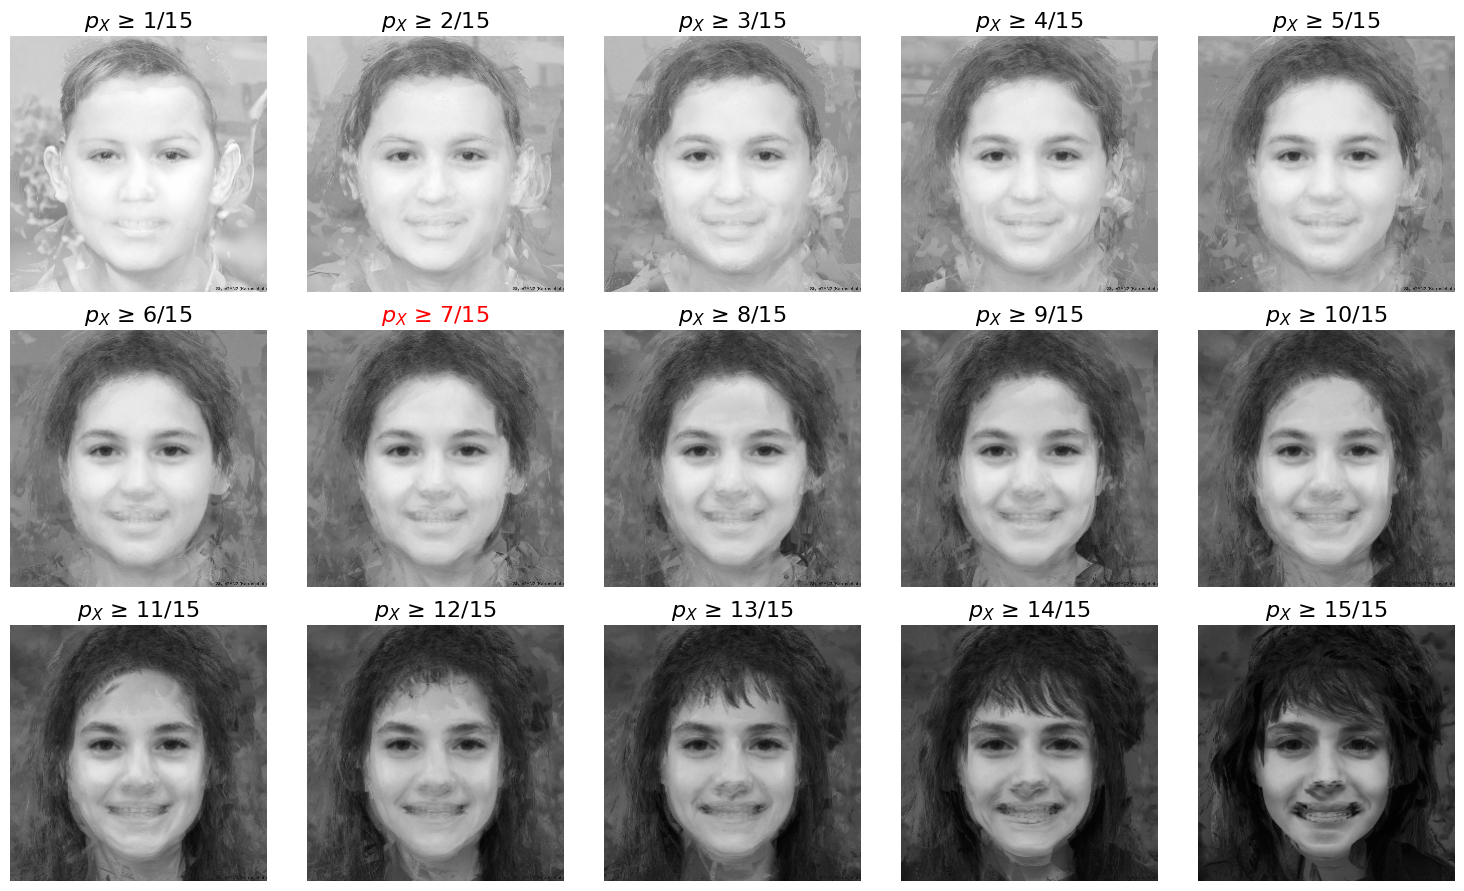

In [9]:
# ukazka pokryvajucej funkcie
# skupina mladsich, cerveny kanal
fig, ax = plt.subplots(3, 5, figsize=(15,9))
plt.setp(ax, aspect="equal")

for level in range(1,16):
    im = set_indicator_to_values(RS_young.RCS["red"].coverage_level_set(level)[0])
    axx = ax[(level-1)//5, (level-1)%5]
    imshow(im, axx)
    axx.set_title(f"$p_X$ ≥ {level}/15", fontsize=16, color="r" if level==RS_young.RCS["red"]._vorobyev_choosed_level else "black")
    axx.axis("off")

plt.tight_layout()
plt.show()